# Versions

The Software Source Code (SSC) used in the Proteomes Journal article to which the present Jupyter Notebook refers to is written in **Python 3** (3.7.6). The main Python modules used along the present SSC are:
+ pandas (1.2.1)
+ numpy (1.19.2)
+ Bio (1.76)
+ sklearn (0.22.1)
+ bokeh (2.2.3)
+ plotnine (0.7.1)
+ seaborn (0.11.1)

In addition, we also used some supporting Python modules:
+ os (-)
+ re (2.2.1)
+ sys (-)
+ math (-)
+ random (-)

# Style

We tried to write this SSC as readable and self explanatory as we could. You should find a very brief comment-line preceding (almost) each code-line. We are aware that this could be too verbose for ultra-advanced Python coders, but our intention is to make this SSC as accessible as possible. In any case, if you have problems when re-using this SSC (or when adapting it to your project), please don't hesitate to contact any corresponding author of the Proteomes Journal article.

# Acronyms

+ **PrSM**: Proteoform Spectrum Match.
+ **PTM**: Post-Translational Modification.
+ **PS**: ProSight PD.
+ **TP**: TopPIC Suite.

# SSC

We have organized this SSC in 19 major sections. In any case, you should be able to run the whole script in a "sequence shot" fashion just by doing `Run`, `Run All Cells` on the Jupyter Notebook bar.

* **Part 0** - Preamble
* **Part 1** - Loading ProSight and TopPIC data
* **Part 2** - Harmonizing ProSight and TopPIC data
* **Part 3** - Data wrangling
* **Part 4** - DBSCAN parameters optimization with Bokeh
* **Part 5** - Filtering PrSMs by intensity and retention time
* **Part 6** - DBSCAN
* **Part 7** - Cluster annotation (automatic phase)
* **Part 8** - Cluster annotation (manual phase)
* **Part 9** - Reproducing **Table 1**
* **Part 10** - Reproducing **Figure 3**
* **Part 11** - Reproducing **Supplementary Figure 1**
* **Part 12** - Reproducing **Supplementary Figure 2**
* **Part 13** - Reproducing **Supplementary Figure 3**
* **Part 14** - LandScape plots preparation
* **Part 15** - Reproducing **Figure 4** (LandScapes)
* **Part 16** - Ratio plots preparation
* **Part 17** - Reproducing **Figure 4** (Ratios)
* **Part 18** - PTMs localization plots preparation
* **Part 19** - Reproducing **Figure 5**

## Part 0 - Preamble

In this part we import all Python modules we need (be sure you have all these modules installed in your machine before going downstream) and some "User Defined Functions" that we prepared in a separate file called `Proteomes_engine.py`.

In [1]:
# Importing supporting packages
import os
import re
import random

# Importing pandas and numpy packages
import pandas as pd
import numpy as np

# Importing plotnine and seaborn plotting packages
import seaborn as sns
import plotnine as p9

# Importing plotnine tools explicitely in order to save code wording 
from plotnine import ggplot, aes, ggtitle, xlab, ylab, xlim, ylim, facet_wrap, facet_grid, guides, guide_legend, element_text, element_blank
from plotnine import scale_size, scale_fill_manual, scale_color_manual, position_jitterdodge, position_dodge2
from plotnine import geom_point, geom_bar, geom_col, geom_errorbar, geom_boxplot, geom_rect, theme_bw, theme
# Writing just "ggplot" is better than "p9.ggplot"

# Importing biopython tools
from Bio.SeqUtils import molecular_weight

# Importing all UDFs within Proteomes_engine
import Proteomes_engine as sperm

We also define a couple of dictionaries with some variables which particular values should be tunned when reusing this code.

In [2]:
# Defining experimental design dictionary: e
e = {
     # Defining experimental design categories
     0: 'BioRep', 1: 'TechRep'
     }

# Defining project dictionary: p
p = {
     # Defining DBSCAN hyperparameters
     'ε':     0.0012,
     'n_min': 10,

     # Defining mass lower and upper limits to filter-in
     'm_lower_lim': 6100,
     'm_upper_lim': 18000,

     # Defining z-score of log2 I lower and upper limits to filter-in
     'z-i_lower_lim': -10,
     'z-i_upper_lim': +10,

     # Defining retention time lower and upper limits to filter-in
     'rt_lower_lim': 0,
     'rt_upper_lim': 42,
     }

We define a "protein" fasta dictionary with the four protamines (Protamine 1, Protamine 2 precursor, Protamine 2 precursor isoform 2 and Protamine 2 precursor isoform 3) full sequences. This dictionary will be used to get the Start and Stop positions of each PrSMs.

In [3]:
# Collecting Proteins FASTA (Determine start and stop positions)
p_fasta = {
           'P1':     'MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPRCRRH',
           'pre-P2': 'MVRYRVRSLSERSHEVYRQQLHGQEQGHHGQEEQGLSPEHVEVYERTHGQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH',
           'P2-2':   'MVRYRVRSLSERSHEVYRQQLHGQEQGHHGQEEQGLSPEHVEVYERTHGQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRESLGDPLNQNFLSQKAAEPGREHAEGTKLPGPLTPSWKLRKSRPKHQVRP',
           }

Now we define a "proteoform" fasta dictionary with all the potential unmodified protamine proteoforms. This dictionary will be used to compute the mass of each proteoform and this, in turn, will be used to estimate the experimental mass shifts.

In [4]:
# Collecting Proteoforms FASTA (Annotate proteoforms and compute mass shifts)
pf_seq_dict = {
               'P1':                                                        'ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPRCRRH',
               'pre-P2': 'VRYRVRSLSERSHEVYRQQLHGQEQGHHGQEEQGLSPEHVEVYERTHGQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH',
               'HPI2':                       'HGQEQGHHGQEEQGLSPEHVEVYERTHGQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH',
               'HPS1':                                   'QGLSPEHVEVYERTHGQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH',
               'HPS2':                                      'SPEHVEVYERTHGQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH',
               'HP4':                                               'ERTHGQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH',
               'HP2':                                                'RTHGQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH',
               'HP3':                                                   'GQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH',
               'P2-2':   'VRYRVRSLSERSHEVYRQQLHGQEQGHHGQEEQGLSPEHVEVYERTHGQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRESLGDPLNQNFLSQKAAEPGREHAEGTKLPGPLTPSWKLRKSRPKHQVRP',
               }

# Initiating empty list to compute / store pf masses in incomming for loop
mass_list = []

# Computing and storing the pf masses of our pf FASTA dictionary
for seq in pf_seq_dict.values():

    # Computing the monoisotopic molecular weight of running pf sequence
    mass = molecular_weight(seq, seq_type='protein', monoisotopic=True)

    # Storing the monoisotopic molecular weight of running pf sequence
    mass_list.append(mass)

del seq, mass

The wet-lab protocol we used blocks all cysteine residues (C) present in our protamine proteoforms with carbamidomethylation (+57 Da). Thus we must correct the masses of our sequences according this fully carbamidomethylated state.

In [5]:
# Computing number of cysteines present in each sequence and multiplying by +57
mass_cys_list = [seq.count('C') * 57.021464 for seq in pf_seq_dict.values()]

# Correcting 'mass_l' by adding 'Cys_mass_l': corrected_mass_a
mass_corrected_list = list(np.array(mass_list) + np.array(mass_cys_list))

# Creating a dictionary with the mass of each protein
pf_mass_dict = dict(zip(pf_seq_dict.keys(), mass_corrected_list))

# Creating a dictionary with the protein name of each sequence
seq_pf_dict = dict(zip(pf_seq_dict.values(), pf_seq_dict.keys()))

del mass_list, mass_cys_list, mass_corrected_list

## Part 1 - Loading ProSight and TopPIC data

Now we import the PrSM data just as provided by PS.

In [6]:
# Initializing empty list for incomming importing
PS_l = []

# Reading ProSight file names
PS_f = [f for f in os.listdir(f'{os.getcwd()}\\Input\\Ps') if '.zip' in f]

# For each file name in ProSight files name list...
for f in PS_f:

    # ... read it as a DataFrame and...
    PS = pd.read_csv(f'{os.getcwd()}\\Input\\Ps\\{f}', sep='\t', low_memory=False)

    # ... append it to the empty list
    PS_l.append(PS)

del f, PS, PS_f

# Concatenating all ProSight DataFrames into a single ProSight DataFrame
PS_df = pd.concat(PS_l, axis=0, ignore_index=True)
del PS_l

# Dropping columns that slow-down DataFrame inspection
for col in ['External Top Down Displays', 'Fragment Map']:

    try:
        PS_df.drop(columns=[col], inplace=True)

    except KeyError:
        pass

del col

# Masking the well ranked in PS_df
rank0_μ = PS_df['Search Engine Rank'] < 3  # Get only 1st & 2nd
rank1_μ = PS_df['Rank'] == 1  # Get only 1st

# Masking good confidence in PS_df
conf_μ = PS_df['Confidence'].isin(['High', 'Medium'])

# Filtering the well ranked and good confidence in PS_df
PS_df = PS_df[rank0_μ & rank1_μ & conf_μ].copy()
del rank0_μ, rank1_μ, conf_μ

# Correcting the mass in PS_df
PS_df['MH [Da]'] = PS_df['Mass [Da]'] - 1.007276466879

# Adding a column with the 'Node'
PS_df['Node'] = 'PS'

Now we import the PrSM data just as provided by TP.

In [7]:
# Initializing empty list for incomming importing
TP_l = []

# Reading TopPIC file names
TP_f = [f for f in os.listdir(f'{os.getcwd()}\\Input\\Tp') if '.zip' in f]

# For each file name in TopPic files name list...
for f in TP_f:

    # ... read it as a DataFrame and...
    TP = pd.read_csv(f'{os.getcwd()}\\Input\\Tp\\{f}', sep='\t', header=26)

    # ... append it
    TP_l.append(TP)

del f, TP, TP_f

# Concatenating all TopPic DataFrames
TP_df = pd.concat(TP_l, axis=0, ignore_index=True)
del TP_l

# Taking the file name from the file complete path
TP_df['Data file name'] = TP_df['Data file name'].str.split('/').str[-1]

# Adding a column with the 'Node'
TP_df['Node'] = 'TP'

## Part 2 - Harmonizing ProSight and TopPIC data

Before getting  the `'Start'` and `'Stop'` positions of each PrSM for PS and TP, we need to get a "cleaned" `'Sequence'` column for TP from the "dirty" `'Proteoform'` column.

In [8]:
# Parsing 'Proteoform' to get rid of the X. and .X residues and storing them in 'Sequence'
TP_df['Sequence'] = TP_df['Proteoform'].apply(lambda i: re.findall(r'\..*\.', i)[0])

# Initiating replacing dictionary to clean sequences in TP_df['Sequence']
clean_dict = {
              r'\(':      '',
              r'\)':      '',
              r'\.':      '',
              r'\[.*?\]': '',
              }

# Cleaning sequences in 'Sequence' column
TP_df['Sequence'] = TP_df['Sequence'].replace(clean_dict, regex=True)

del clean_dict

Once we get a cleaned `'Sequence'` column for TP, we can get the `'Start'` and `'Stop'` positions of each PrSM leveraging our USDs called `start_finder` and `stop_finder` from `Proteomes_engine`.

In [9]:
# Initiating DataFrame list for incomming for loop
df_l = [PS_df, TP_df]

# For each DataFrame in df_l...
for df in df_l:

    # ... obtain 'Start' residue positions of each 'Sequence'
    df['Start'] = df['Sequence'].apply(sperm.start_finder, args=(p_fasta, ))

    # ... obtain 'Stop' residue positions of each 'Sequence'
    df['Stop'] = df['Sequence'].apply(sperm.stop_finder, args=(p_fasta, ))

del df, df_l, p_fasta

The node PS gives $-\log_{10} E$. Here we compute the $-\log_{10}$ of the `'E-value'` column from TP in order to harmonize with PS. We also compute $-\log_{10}$ of the `'Q-value'` column from PS because we will need it for the next code chunk.

In [10]:
# Computing the -log10 of the E value (TP)
TP_df['-log E'] = -np.log10(TP_df['E-value'])

# Computing the -log10 of the Q value (PS)
PS_df['-log Q'] = -np.log10(PS_df['Q-value'])

There are some duplicated scans in PS. We will ammend this by keeping those PrSMs with the biggest $-\log_{10} E$ and, in case of a tie, the biggest $-\log_{10} Q$.

In [11]:
# Defining sorting and dropping lists
sorting_l = ['-Log E-Value', '-log Q']
dropping_l = ['Spectrum File', 'Fragmentation Scan(s)', 'Mass [Da]']

# Sorting by E and Q (descending). We want the big ones first!
PS_df.sort_values(by=sorting_l, ascending=False, inplace=True)

# Dropping duplicates (keep first). We want the big ones first!
PS_df.drop_duplicates(subset=dropping_l, keep='first', inplace=True)

# Sorting by index to recover the "original" sorting again
PS_df.sort_index()

del sorting_l, dropping_l

Each node has provides information regarding the PTM localization. Unfortunately, the format of this information is not the same for PS and TP. We need to parse their columns `'Modifications'` and `'MIScore'`. To this aim we coded a couple of (bulky) parser USDs called `PS_parser` and `TP_parser`. As usual, you can find the source code in `Proteomes_engine.py`.

In [12]:
# Applying user-defined fuction to parse 'Modifications' column from PS
PS_df = sperm.PS_parser(PS_df)

# Applying user-defined fuction to parse 'MIScore' column from TP
TP_df = sperm.TP_parser(TP_df)

In addition, we also need to parse `'Modifications'` (PS) and `'Proteoform'` (TP) to get the number of phosphorylations on each PrSM.

In [13]:
# Parsing to get the number of phosphorylations
PS_df['Count (ph)'] = PS_df['Modifications'].str.count(pat='phospho')
TP_df['Count (ph)'] = TP_df['Proteoform'].str.count(pat='Phospho')

Before merging `TP_df` and `PS_df` DataFrame, we need to construct the `'PF ID'` column. The output data from TP already gives this proteoform ID column, but we need to create it by hand for PS.

In [14]:
def shuff(orig):
    '''TODO'''
    random.seed(2020)
    dest = orig[:]
    random.shuffle(dest)
    return dest

# Getting nicely fomatted proteoform ID column from PS
PS_df['PF ID'] = PS_df['Annotated Sequence'] + PS_df['Modifications']
PS_IDs = list(PS_df['PF ID'].unique())
PS_nums = list(range(len(PS_IDs)))
PS_nums_shuff = shuff(PS_nums)
PS_ID_dict = dict(zip(PS_IDs, PS_nums_shuff))
PS_df['Proteoform ID'] = PS_df['PF ID'].map(PS_ID_dict)
PS_df['Proteoform ID'] = PS_df['Proteoform ID'].apply(int)
PS_df['Proteoform ID'] = PS_df['Proteoform ID'].apply(str)
PS_df['Proteoform ID'] = PS_df['Proteoform ID'].str.zfill(3)
PS_df['Proteoform ID'] = PS_df['Node'] + '-' + PS_df['Proteoform ID']

# Getting nicely fomatted proteoform ID column from TP
TP_df['PF ID'] = TP_df['Proteoform ID'].apply(str)
TP_IDs = list(TP_df['PF ID'].unique())
TP_nums = list(range(len(TP_IDs)))
TP_nums_shuff = shuff(TP_nums)
TP_ID_dict = dict(zip(TP_IDs, TP_nums_shuff))
TP_df['Proteoform ID'] = TP_df['PF ID'].map(TP_ID_dict)
TP_df['Proteoform ID'] = TP_df['Proteoform ID'].apply(int)
TP_df['Proteoform ID'] = TP_df['Proteoform ID'].apply(str)
TP_df['Proteoform ID'] = TP_df['Proteoform ID'].str.zfill(3)
TP_df['Proteoform ID'] = TP_df['Node'] + '-' + TP_df['Proteoform ID']

del PS_IDs, PS_nums, PS_ID_dict, PS_nums_shuff
del TP_IDs, TP_nums, TP_ID_dict, TP_nums_shuff

We are in disposition to merge `TP_df` and `PS_df` DataFrames, but we must standardize column names first.

In [15]:
# Initializing empty list for incomming column name standarization
df_l = []

# Standarizing column names in PS
sperm.col_renamer(PS_df)
df_l.append(PS_df)
del PS_df

# Standarizing column names in TP
sperm.col_renamer(TP_df)
df_l.append(TP_df)
del TP_df

Finally, we concatenate both DataFrame (`PS_df` and `TP_df`) into a single, harmonized DataFrame (`df`).

In [16]:
# Concatenating our DataFrames
df = pd.concat(df_l)

# Listing the columns we want to keep after merging
cols = ['File', 'Node', 'Scan', 'Int', 'RT (min)', 'm (Da)',
        'Protein', 'Sequence', 'Ann. Seq.', 'Modifications',
        'Start', 'Stop', 'Targets', 'Positions', 'Positions (abs.)',
        'Probabilities', 'C-Score', '-log E', 'Proteoform ID', 'Count (ph)']

# Slicing-in our columns of interest
df = df[cols].copy()

del cols, df_l

## Part 3 - Data wrangling

Some columns were not present in `PS_df` or `TP_df` before concatenating and now appear as `np.nan`. We should amend this.

In [17]:
# Filling nans with empty strings
string_nan_cols = ['Protein', 'Sequence', 'Modifications']
df[string_nan_cols] = df[string_nan_cols].fillna(' ')

# For each column in the column list...
for col in ['Targets', 'Positions', 'Positions (abs.)', 'Probabilities']:

    # ... mask-in the nans
    nan_μ = df[col].isna()

    # ... fill those nans with empty lists using a lambda trick
    df.loc[nan_μ, col] = df.loc[nan_μ, col].fillna('[]').apply(eval)

del string_nan_cols, nan_μ, col

Now we can extract the experimental design from the spectrum file names stored in the `'File'` column. Remember that we have two biological replicates (`'A'` and `'B'`) with two technical replicates each (`'R01'`, `'R02'` and `'R03'`, `'R04'`, respectively).<a id='Cell_c'></a>

In [18]:
# Removing file extension from the 'File' column
df['File'] = df['File'].str.split('.').str[0]

# Removing "_ms2" tag from 'File' column (only for TP)
df['File'] = df['File'].replace({'_ms2': ''}, regex=True)

# Extracting the experimental desing from the file name
for k in sorted(e.keys(), reverse=True):

    # Incorporating the experimental desing as categorical columns
    df.insert(0, e[k], df['File'].str.split('_').str[k])

del k

Let's compute the Z-score of the logarithm in base 2 of the intensity (`'z log2 Int'`). Notice that the intensity in column `'Int'`.

In [19]:
# Computing the log2 of the intensity
df.insert(loc=df.columns.get_loc('Int') + 1,
          column='log2 Int',
          value=np.log2(df['Int']))

# Defining groupby columns (We want to compute z-score by Node and TechRep)
gb_cols = ['Node', 'TechRep']

# Getting the mean by Node and TechRep
mean = df.groupby(by=gb_cols)['log2 Int'].transform(np.mean)

# Getting the standard deviation by Node and TechRep
std = df.groupby(by=gb_cols)['log2 Int'].transform(np.std)

# Computting the z-score
z = (df['log2 Int'] - mean) / std

# Inserting the z-score of the intensity
df.insert(loc=df.columns.get_loc('log2 Int') + 1,
          column='z log2 Int',
          value=z)

del z, mean, std, gb_cols

We will filter in those PrSMs with masses between 6100 Da and 18000 Da. Remember that the fully carbamidomethylated protamine forms lie in this mass range. Is important to filter the mass **BEFORE** the clustering in order to work with a fixed scaling factor for the mass dimension.

In [20]:
# Masking-in masses
mass_μ = (df['m (Da)'] > p['m_lower_lim']) & (df['m (Da)'] < p['m_upper_lim'])

# Filtering-in masses
df = df[mass_μ].copy()

# Reporting in the console
sum_ = sum(~mass_μ)
len_ = len(mass_μ)
print(f'm --> Dropped {sum_} of {len_} PrSMs ({sum_/len_ * 100:.2f}%)')

del mass_μ, sum_, len_

m --> Dropped 113 of 4746 PrSMs (2.38%)


Saving preclustering.

In [21]:
# Sorting values by 'm (Da)' and resetting index
df = df.sort_values(by='m (Da)')
df.reset_index(drop=True, inplace=True)

# Trying to create the "Output" folder...
try:
    os.makedirs(f'{os.getcwd()}\\Output')

# ... except if it is already created
except FileExistsError:
    pass

# Exporting all dictionaries
np.save(arr=p, file=f'{os.getcwd()}\\Output\\Project_dict.npy')
np.save(arr=e, file=f'{os.getcwd()}\\Output\\Experiment_dict.npy')

# Exporting the main DataFrame
df.to_excel(f'{os.getcwd()}\\Output\\0_PrSMs_preDBSCAN.xlsx', index=False)

## Part 4 - DBSCAN parameters optimization with Bokeh

This part here requires your participation. We will leverage an interactive home-made web app written with the power Python package called "Bokeh" (you can check the source code within the `Proteomes_Bokeh.py` file). A new tab should open in your default web browsers after executing the next code cell. You should see the app dashboard a few seconds later. This app loads the `PrSMs_preDBSCAN.xlsx` file we just exported in the previous code cell and supports you in the task of optimizing $\epsilon$ and $n_{min}$ DBSCAN parameters. By using this app, you can also filter by `'z log2 Int'` and `'RT (min)'` in order to get rid of low quality PrSMs and latest retention times coming from the column wash.

Please, once you finish the optimization process, **shut down the Bokeh app by using the `Stop Bokeh Server` green button present in the dashboard**. If you don't stop the Bokeh app properly, the current kernel session that this Jupyter Notebook uses to compute things will remain busy. If this happens the following code cell will not run and you should restart the kernel by hand.

Once you get your optimum parameters values, you can update the numbers stored within the `p` dictionary defined at the top of the code an rerun the Jupyter Notebook from the very beginning.

In [22]:
# Using the cmd from the same folder where Proteomes_Bokeh.py is located
os.system('bokeh serve --show Proteomes_Bokeh.py')

0

In our work, the values we get were: $\epsilon = 1.2·10^{-3}$ and $n_{min} = 10$. (check the values stored in `p['ε']` and `p['n_min']` that we defined at the beginning of this Jupyter Notebook):

In [23]:
# Printing epsilon and n_min values> 
print(p['ε'])
print(p['n_min'])

0.0012
10


The filtering values for the intensity we get were: $log_{2}(I_{z})_{min} = -10$ and $log_{2}(I_{z})_{max} = 10$. As you can see, we don't filtered out any PrSMs by their intensity, we just grab them all (check the values stored in `z-i_lower_lim` and `z-i_upper_lim` that we defined at the beginning of this Jupyter Notebook):

In [24]:
# Printing filtering window for the intensity (log2 of z-score of I) 
print(p['z-i_lower_lim'])
print(p['z-i_upper_lim'])

-10
10


The filtering values for the retention time we get were: $RT_{min} = 0$ minutes and $RT_{max} = 42$ minutes. We filtered out those PrSMs coming from the latest retention times for being from the column wash (check the values stored in `rt_lower_lim` and `rt_upper_lim` that we defined at the beginning of this Jupyter Notebook):

In [25]:
# Printing filtering window for the retention time (log2 of z-score of I) 
print(p['rt_lower_lim'])
print(p['rt_upper_lim'])

0
42


## Part 5 - Filtering PrSMs by intensity and retention time

Here we will apply the filtering windows we just get thanks to the Bokeh app.

In [26]:
# Masking-in intensity z-score
zint_μ = (df['z log2 Int'] > p['z-i_lower_lim']) & (df['z log2 Int'] < p['z-i_upper_lim'])

# Filtering-in intensity z-score
df = df[zint_μ].copy()

# Reporting in the console
sum_ = sum(~zint_μ)
len_ = len(zint_μ)
print(f'I --> Dropped {sum_} of {len_} PrSMs ({sum_/len_ * 100:.2f}%)')

del zint_μ, sum_, len_

I --> Dropped 0 of 4633 PrSMs (0.00%)


In [27]:
# Masking-in retention time
rt_μ = (df['RT (min)'] > p['rt_lower_lim']) & (df['RT (min)'] < p['rt_upper_lim'])

# Filtering-in retention time
df = df[rt_μ].copy()

# Reporting in the console
sum_ = sum(~rt_μ)
len_ = len(rt_μ)
print(f't --> Dropped {sum_} of {len_} PrSMs ({sum_/len_ * 100:.2f}%)')

del rt_μ, sum_, len_

t --> Dropped 1795 of 4633 PrSMs (38.74%)


Therefore, we will sent to the final DBSCAN algorithm 2838 PrSMs in total (56.6% from PS and 43.4% from TP):

In [28]:
# Printing the total number of PrSMs (absolute) we will send to DBSCAN (by Node)
print(df['Node'].value_counts())

# Printing the total number of PrSMs (relative) we will send to DBSCAN (by Node)
print(df['Node'].value_counts()/len(df['Node']) * 100)

PS    1607
TP    1231
Name: Node, dtype: int64
PS    56.624383
TP    43.375617
Name: Node, dtype: float64


## Part 6 - DBSCAN

Now we will perform the DBSCAN clustering. This time we only clustered the `'m (Da)'`, but the idea is to cluster both `'m (Da)'` and `'RT (min)'` in the future.

In [29]:
# Clustering with DBSCAN after filtering
sperm.DBSCAN_clustering(data=df, eps=p['ε'], min_samples=p['n_min'])

The clustering size is 1.2764662486884761 Da.


After clustering, we successfully clustered 2578 PrSMs in total (55.9% from PS and 44.1% from TP):

In [30]:
# Printing the total number of clustered PrSMs (absolute) (by Node)
c_μ = df['Cluster'] != 'Unclustered'
print(df[c_μ]['Node'].value_counts())

# Printing the total number of clustered PrSMs (relative) (by Node)
print(df[c_μ]['Node'].value_counts() / len(df[c_μ]) * 100)

del c_μ

PS    1441
TP    1137
Name: Node, dtype: int64
PS    55.896043
TP    44.103957
Name: Node, dtype: float64


Notice that 260 PrSMs remained as unclustered (63.8% from PS and 36.2% from TP):

In [31]:
# Printing the total number of unclustered PrSMs (absolute) (by Node)
uc_μ = df['Cluster'] == 'Unclustered'
print(df[uc_μ]['Node'].value_counts())

# Printing the total number of unclustered PrSMs (relative) (by Node)
print(df[uc_μ]['Node'].value_counts() / len(df[uc_μ]) * 100)

del uc_μ

PS    166
TP     94
Name: Node, dtype: int64
PS    63.846154
TP    36.153846
Name: Node, dtype: float64


## Part 7 - Cluster annotation (automatic phase)

At this point we will perform a couple of protein searches (`'Protein (own search)'` and `'Proteins (own search)'`) to support the automatic cluster annotation.

In [32]:
def protein_search(seq, seq_d):
    '''Protein (single) search (with full sequence match)'''
    if seq in seq_d:
        return seq_d.get(seq)
    else:
        return 'Unidentified'


def proteins_search(seq, seq_d):
    '''Proteins (multiple) search (with partial sequence match)'''
    proteins = []
    for protein, protein_name in seq_d.items():
        if seq in protein:
            proteins.append(protein_name)
    return proteins


# Searching if the sequence has a full match with a protein
df.insert(loc=df.columns.get_loc('Protein') + 1,
          column='Protein (own search)',
          value=df['Sequence'].apply(protein_search, args=[seq_pf_dict]))

# Searching if the sequence has a partial match with some proteins
df.insert(loc=df.columns.get_loc('Protein') + 2,
          column='Proteins (own search)',
          value=df['Sequence'].apply(proteins_search, args=[seq_pf_dict]))

Before starting the automatic cluster annotation process, we will prepare the skeleton of the `cluster_df`.

In [33]:
# Grouping by and aggregating 'Hits' with 'count'
hits_df = df.groupby(by=['Cluster', 'Protein (own search)'], as_index=False).agg(Hits=('Scan', 'count'))

# Grouping by and aggregating 'Hits' with max as 'Hits' and with sum as 'Size'
cluster_df = hits_df.groupby(by=['Cluster']).agg(Hits=('Hits', 'max'),  Size=('Hits', 'sum'))

# Getting cluster 'Hits' / 'Size' ratio
cluster_df['Ratio'] = (cluster_df['Hits'] / cluster_df['Size']).round(3)

The automatic cluster annotation process provisionally pre-assigns a protamine form to each cluster. To do that, we will assign to each cluster the protamine form with more hits within such cluster.

In [34]:
# Grouping by 'Cluster' w/o aggregating and storing the indices with max 'Hits'
index_max = hits_df.groupby(['Cluster'])['Hits'].idxmax()

# Slicing-in the the "champion" proteins hits
champions_df = hits_df.loc[index_max]

# Setting the champion clusters as index of the DataFrame
champions_df.index = champions_df['Cluster']

# Storing the "champion" proteins hits to the clusters
cluster_df['Cluster - Protein (Auto)'] = champions_df['Protein (own search)']

del champions_df, index_max

Now, we can annotate all the PrSMs in the `df` with this provisional protamine form pre-assignation.

In [35]:
# Creating dictionary linking a successful proteins with their clusters
cluster_dict = dict(zip(cluster_df.index, cluster_df['Cluster - Protein (Auto)']))

# Inserting the clusters to our data
df.insert(loc=df.columns.get_loc('Cluster') + 1,
          column='Cluster - Protein (Auto)',
          value=df['Cluster'].map(cluster_dict))

del cluster_dict, hits_df

After annotating "some" PrSMs with a provisional protamine form, we can determine "some" provisional PrSMs mass shifts in our `df` DataFrame. Notice that we can only determine these provisional delta masses for those PrSMs having a provisional protamine form assigned. <a id='Cell_a'></a>

In [36]:
def Δm_computer(mass, protein, mass_dict):
    '''Computes the mass shift of a PrSM given its mass and its cluster protein'''
    if protein in mass_dict:
        return mass - mass_dict[protein]
    else:
        return np.nan


# Computing the delta mass in the case of having a successful (auto) cluster
Δm_ser = df.apply(lambda f: Δm_computer(f['m (Da)'],
                                        f['Cluster - Protein (Auto)'],
                                        pf_mass_dict), axis=1)

# Adding the delta mass to our DataFrame
df.insert(loc=df.columns.get_loc('m (Da)') + 1,
          column='Δm (Da) (Auto)',
          value=Δm_ser)

del Δm_ser

Additionally, we can compute the mean mass and mean mass shift for each cluster (`'Cluster - m (Da)'` and ` 'Cluster - Δm (Da) (Auto)'`, respectively) to get the cluster annotation DataFrame (`cluster_df`).

In [37]:
# Computing the caracteristic 'm (Da)' and 'Δm (Da) (Auto)' for each cluster
mass_df = df.groupby(['Cluster']).agg({'m (Da)': 'mean', 'Δm (Da) (Auto)': 'mean'})

# Defining renaming dictionary for the mass_df (aesthetics)
rename_dict = {'m (Da)': 'Cluster - m (Da)', 'Δm (Da) (Auto)': 'Cluster - Δm (Da) (Auto)'}

# Renaming Cluster DataFrame columns
mass_df.rename(columns=rename_dict, inplace=True)

del rename_dict

# Incorporating mean 'm (Da)' and 'Δm (Da) (Auto)' to cluster_df
cluster_df = pd.concat([cluster_df, mass_df], axis=1)

# Inserting the "unknown" 'Protein (Revised)' column
cluster_df.insert(loc=cluster_df.columns.get_loc('Cluster - Protein (Auto)') + 1,
                  column='Cluster - Protein (Revised)',
                  value='Unknown')

# Inserting "unknown" 'Proteoform (Revised)'and Modification (Revised)' columns
cluster_df['Cluster - Proteoform (Revised)'] = 'Unknown'
cluster_df['Cluster - Modification (Revised)'] = 'Unknown'

del mass_df

Finally, we are able to export the PrSM DataFrame (`df`) and the cluster annotation DataFrame (`cluster_df`).

In [38]:
# Exporting the main DataFrame
df.to_excel(f'{os.getcwd()}\\Output\\1_PrSMs_postDBSCAN.xlsx', index=False)

# Trying to create the "Annotation" folder...
try:
    os.makedirs(f'{os.getcwd()}\\Output\\Annotation')

# ... only if it is already created
except FileExistsError:
    pass

# Exporting the cluster hits DataFrame and cluster automatic annotation
cluster_df.to_excel(f'{os.getcwd()}\\Output\\Annotation\\Cluster.xlsx')

del cluster_df

## Part 8 - Cluster annotation (manual phase)

At this moment the automatic cluster annotation requires manual validation. To this aim we duplicated the `Cluster.xlsx` spreadsheet we just exported by hand as a new `Cluster (Revised).xlsx` spreadsheet. Then we open and manually annotate the columns `'Cluster - Protein (Revised)'`, `'Cluster - Proteoform (Revised)'` and `'Cluster - Modification (Revised)'` whenever is possible.

In [39]:
# Import the Cluster human annotation
cluster_rev_df = pd.read_excel(f'{os.getcwd()}\\Output\\Annotation\\Cluster (Revised).xlsx', index_col='Cluster', engine='openpyxl')

After manual validation, we should update some mass shift values within `cluster_rev_df`.

In [40]:
def Δm(mass, protein, mass_dict):
    '''Computes the mass shift of a PrSM given its mass and its cluster protein'''
    if protein in mass_dict:
        return mass - mass_dict[protein]
    else:
        return np.nan


# Updating the Δm after the human annotation
Δm_ser = cluster_rev_df.apply(lambda f: Δm(f['Cluster - m (Da)'],
                                           f['Cluster - Protein (Revised)'],
                                           pf_mass_dict), axis=1)

# Adding the updated Δm to our Cluster DataFrame
cluster_rev_df.insert(loc=cluster_rev_df.columns.get_loc('Cluster - Δm (Da) (Auto)') + 1,
                      column='Cluster - Δm (Da) (Revised)',
                      value=Δm_ser)

del Δm_ser

Since now we have a nice and well annotated `cluster_rev_df` DataFrame, we will use it to annotate all the PrSMs within our `df` DataFrame by linking their corresponding clusters.

In [41]:
# Getting the cluster list for incomming (multiple) annotations
clusters = cluster_rev_df.index

# Annotating 'Cluster - Δm (Da) (Revised)'
map_dict = dict(zip(clusters, cluster_rev_df['Cluster - Δm (Da) (Revised)']))
df.insert(loc=df.columns.get_loc('Cluster') + 1,
          column='Cluster - Δm (Da) (Revised)',
          value=df['Cluster'].map(map_dict))

# Annotating 'Cluster - m (Da)'
map_dict = dict(zip(clusters, cluster_rev_df['Cluster - m (Da)']))
df.insert(loc=df.columns.get_loc('Cluster') + 1,
          column='Cluster - m (Da)',
          value=df['Cluster'].map(map_dict))

# Annotating 'Cluster - Modification (Revised)'
map_dict = dict(zip(clusters, cluster_rev_df['Cluster - Modification (Revised)']))
df.insert(loc=df.columns.get_loc('Cluster - Δm (Da) (Revised)') + 1,
          column='Cluster - Modification (Revised)',
          value=df['Cluster'].map(map_dict))

# Annotating 'Cluster - Proteoform (Revised)'
map_dict = dict(zip(clusters, cluster_rev_df['Cluster - Proteoform (Revised)']))
df.insert(loc=df.columns.get_loc('Cluster - Δm (Da) (Revised)') + 1,
          column='Cluster - Proteoform (Revised)',
          value=df['Cluster'].map(map_dict))

# Annotating 'Cluster - Protein (Revised)'
map_dict = dict(zip(clusters, cluster_rev_df['Cluster - Protein (Revised)']))
df.insert(loc=df.columns.get_loc('Cluster - Δm (Da) (Revised)') + 1,
          column='Cluster - Protein (Revised)',
          value=df['Cluster'].map(map_dict))

# Creating 'Cluster → Proteoform' column to use when plotting figures (easthetics)
df['Cluster → Proteoform'] = df['Cluster'] + ' → ' + df['Cluster - Proteoform (Revised)']

del clusters, map_dict

Similarly as we did in this previous [code cell](#Cell_a), we can now recompute the mass shift but now referred to the `'Cluster - Protein (Revised)'` instead of the `'Cluster - Protein (Auto)'`.

In [42]:
# Computing the delta mass in the case of having a successful (revised) cluster
Δm_ser = df.apply(lambda f: Δm(f['m (Da)'],
                               f['Cluster - Protein (Revised)'],
                               pf_mass_dict), axis=1)

# Adding the delta mass to our DataFrame
df.insert(loc=df.columns.get_loc('Δm (Da) (Auto)') + 1,
          column='Δm (Da) (Revised)',
          value=Δm_ser)

del Δm_ser

Finally, we should export the resulting cluster annotation DataFrame (`cluster_rev_df`) and PrSMs DataFrame (`df`)

In [43]:
# Exporting the updated Cluster DataFrame
cluster_rev_df.to_excel(f'{os.getcwd()}\\Output\\2_Protamine_Ann (Table S1).xlsx', index=True)

# Exporting the main DataFrame with proteoform annotation after clustering
df.to_excel(f'{os.getcwd()}\\Output\\3_PrSMs_postDBSCAN_Ann (Table S2).xlsx', index=False)

**Note**: These two files are mentioned as a part of the supplementary material in the paper body, namely as **Table S1** and **Table S2**.

## Part 9 - Reproducing Table 1

Before generating **Table 1**, we need to round some magnitudes to avoid being to cumbersome. Notice that columns `'m_T (Da)'`,  `'m_C (Da)'` and  `'Δm_CT (Da)'` correspond to the three magnitudes appearing in the Equation 2 from the paper as  $m_T$, $m_C$ and $\Delta m_{CT}$, respectively.

In [44]:
# Creating some columns with rounded values and new names (just to get nicer header names in upcomming pivot table)
pf_mass_round_dict = {k: round(pf_mass_dict[k], 2) for k in pf_mass_dict} 
df['m_T (Da)'] = df['Cluster - Proteoform (Revised)'].replace(pf_mass_round_dict)
df['m_C (Da)'] = df['Cluster - m (Da)'].round(2)
df['Δm_CT (Da)'] = df['Cluster - Δm (Da) (Revised)'].round(2)

In this section we will reproduce **Table 1** appearing in the paper.

In [45]:
# Duplicating some columns with new names (just to get nicer header names in upcomming pivot table)
df['Proteoform'] = df['Cluster - Proteoform (Revised)'].copy()
df['PF count'] = df['Proteoform ID'].copy()
df['PrSM count'] = df['Scan'].copy()

# Filling nan values in 'Δm_CT' column (just to not lose associated rows in upcomming pivot table)
df['Δm_CT (Da)'].fillna('Unknown', inplace=True)

# Pivoting and aggregating:
#'PF count' with number of distinct observations ('nunique')
#'PF count' with number observations ('count')
tab2 = pd.pivot_table(
                      df,
                      values=['PF count', 'PrSM count'],
                      index=['Cluster', 'Proteoform', 'm_T (Da)', 'm_C (Da)', 'Δm_CT (Da)'],
                      columns=['Node'],
                      aggfunc={'PF count': 'nunique', 'PrSM count': 'count'},
                      )
# Showing tab2
tab2

PF count        \
Node                                                                PS    TP   
Cluster     Proteoform     m_T (Da)       m_C (Da) Δm_CT (Da)                  
P|000       P1             7029.6         7029.45  -0.14           2.0   5.0   
P|001       P1 +1(61)      P1 +1(61)      7090.92  61.32           5.0   4.0   
P|002       P1 +1ph        P1 +1ph        7108.86  79.27           3.0   5.0   
P|003       P1 +2(61)      P1 +2(61)      7151.59  122.0           6.0   3.0   
P|004       P1 +1ph +1(61) P1 +1ph +1(61) 7170.39  140.79          2.0   3.0   
P|005       P1 +3(61)      P1 +3(61)      7212.91  183.32          4.0   3.0   
P|006       P1 +1ph +2(61) P1 +1ph +2(61) 7231.82  202.23          6.0   2.0   
P|007       P1 +1ph +3(61) P1 +1ph +3(61) 7293.52  263.92          4.0   5.0   
P|008       P1 +2ph +2(61) P1 +2ph +2(61) 7310.92  281.32          3.0   2.0   
P|009       HP3            7539.07        7538.54  -0.53           2.0   2.0   
P|010       HP3 +1(61)     HP3 +1(61)     7599.63  60.56           1.0   2.0   
P|011       HP2            7933.28        7932.73  -0.55           1.0   4.0   
P|012       HP2 +1(61)     HP2 +1(61)     7994.03  60.75           1.0   1.0   
P|013       HP4 +1(61)     HP4 +1(61)     8122.66  60.34           2.0   NaN   
P|014       HPS2           9002.75        9002.09  -0.66           2.0   3.0   
P|015       HPS2 +1(61)    HPS2 +1(61)    9063.40  60.66           2.0   3.0   
P|016       HPS1 -1Q       HPS1 -1Q       9172.08  -128.83         3.0   1.0   
P|017       HPS1 +1Pyroglu HPS1 +1Pyroglu 9283.32  -17.59          9.0   3.0   
P|018       HPS1           9300.91        9301.17  0.25            1.0   3.0   
P|019       HPS1 +1(61)    HPS1 +1(61)    9363.59  62.67           3.0   2.0   
P|020       HPI2           10654.46       10653.97 -0.49           1.0   1.0   
P|021       pre-P2         13196.82       13195.97 -0.85           1.0   4.0   
P|022       pre-P2 +1ph    pre-P2 +1ph    13275.94 79.12           3.0   4.0   
P|023       pre-P2 +2ph    pre-P2 +2ph    13355.92 159.1           1.0   5.0   
P|024       pre-P2 +3ph    pre-P2 +3ph    13435.64 238.82          3.0   3.0   
P|025       pre-P2 +4ph    pre-P2 +4ph    13515.50 318.68          2.0   2.0   
P|026       Unknown        Unknown        13873.22 Unknown         NaN   2.0   
Unclustered Unknown        Unknown        10326.54 Unknown        57.0  89.0   

                                                              PrSM count  \
Node                                                                  PS   
Cluster     Proteoform     m_T (Da)       m_C (Da) Δm_CT (Da)              
P|000       P1             7029.6         7029.45  -0.14           247.0   
P|001       P1 +1(61)      P1 +1(61)      7090.92  61.32           156.0   
P|002       P1 +1ph        P1 +1ph        7108.86  79.27            71.0   
P|003       P1 +2(61)      P1 +2(61)      7151.59  122.0            71.0   
P|004       P1 +1ph +1(61) P1 +1ph +1(61) 7170.39  140.79           51.0   
P|005       P1 +3(61)      P1 +3(61)      7212.91  183.32           64.0   
P|006       P1 +1ph +2(61) P1 +1ph +2(61) 7231.82  202.23           29.0   
P|007       P1 +1ph +3(61) P1 +1ph +3(61) 7293.52  263.92           42.0   
P|008       P1 +2ph +2(61) P1 +2ph +2(61) 7310.92  281.32            7.0   
P|009       HP3            7539.07        7538.54  -0.53            72.0   
P|010       HP3 +1(61)     HP3 +1(61)     7599.63  60.56            17.0   
P|011       HP2            7933.28        7932.73  -0.55           142.0   
P|012       HP2 +1(61)     HP2 +1(61)     7994.03  60.75            64.0   
P|013       HP4 +1(61)     HP4 +1(61)     8122.66  60.34            16.0   
P|014       HPS2           9002.75        9002.09  -0.66            69.0   
P|015       HPS2 +1(61)    HPS2 +1(61)    9063.40  60.66            31.0   
P|016       HPS1 -1Q       HPS1 -1Q       9172.08  -128.83          23.0   
P|017       HPS1 +1Pyroglu HPS1 +1Pyroglu 9283.32  -17.59    

In the Subsection 3.2.1 from the paper we give `'mean'` and `'max'` number of proteoforms per cluster according to PS and TP. Let's reproduce these numbers.

In [46]:
# Dropping the Unclustered row from tab2
tab2.drop(labels=['Unclustered'], axis=0, inplace=True)

# Computing the mean number of proteoforms per cluster for PS and TP
print(tab2['PF count'].apply('mean'))

# Computing the top number of proteoforms per cluster for PS and TP
print(tab2['PF count'].apply('max'))

Node
PS    2.807692
TP    2.961538
dtype: float64
Node
PS    9.0
TP    5.0
dtype: float64


In [47]:
# Drop redundant columns
df.drop(columns=['Proteoform', 'PF count', 'PrSM count', 'm_T (Da)', 'Δm_CT (Da)', 'm_C (Da)'], inplace=True)

del pf_mass_round_dict, tab2

## Part 10 - Reproducing Figure 3

Here we will reproduce **Figure 3a** just as appears in the paper.

In [48]:
# Trying to create the "Figures" folder...
try:
    os.makedirs(f'{os.getcwd()}\\Output\\Figures\\png')
    os.makedirs(f'{os.getcwd()}\\Output\\Figures\\pdf')
    os.makedirs(f'{os.getcwd()}\\Output\\SupplementaryFigures\\png')
    os.makedirs(f'{os.getcwd()}\\Output\\SupplementaryFigures\\pdf')

# ... only if it is already created
except FileExistsError:
    pass

C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.


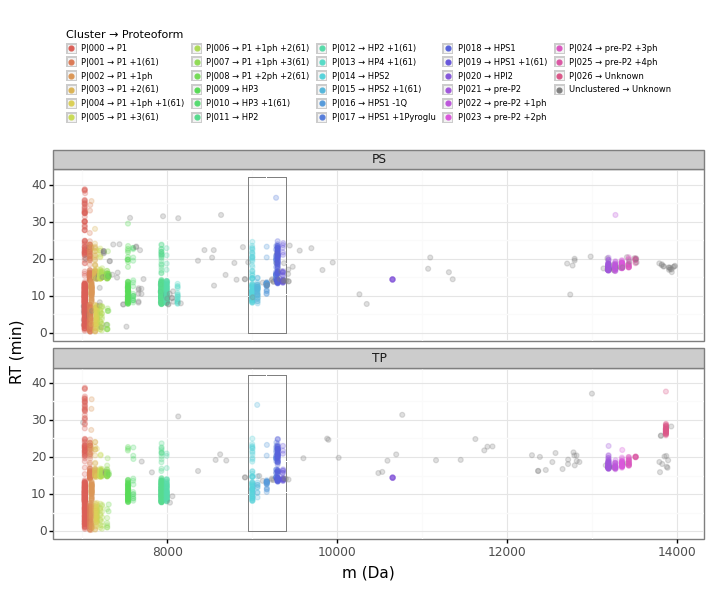

<ggplot: (-9223371930412065640)>

In [49]:
# Generating a palette with a different color for each cluster
pal = sns.color_palette('hls', len(df['Cluster → Proteoform'].unique()))

# HEX-converting the palette to make it suitable for ggplot
pal = list(pal.as_hex())

# Defining the last color of the palette as grey (for unclustered PrSMs)
pal[-1] = '#808080'

# Defining the figure size 1.2 x (7, 4)
p9.options.figure_size = (8.4, 4.8)

# Generating our ggplot
Fig3a = (ggplot(
                df[(df['m (Da)'] > 7000) & (df['m (Da)'] < 14000)].copy(),
                aes(
                    x='m (Da)',
                    y='RT (min)',
                    color='Cluster → Proteoform',
                    fill='Cluster → Proteoform',
                    )
                )
         + geom_point(
                      alpha=0.25,
                      )
         + geom_rect(
                     mapping=aes(xmin=8950, xmax=9400, ymin=0, ymax=42),
                     linetype='dotted',
                     color='#808080',
                     fill='#808080',
                     alpha=0,
                     size=0.25
                     )
         + facet_wrap(facets=['Node'], ncol=1)
         + scale_fill_manual(values=pal)
         + scale_color_manual(values=pal)
         + guides(colour=guide_legend(override_aes={'alpha': 1}))
         + theme_bw()
         + theme(
                 legend_position="top",
                 legend_key_size=7,
                 legend_title=element_text(size=8),
                 legend_text=element_text(size=6)
                 )
         )

# Saving our ggplot
Fig3a.save(filename=f'{os.getcwd()}\\Output\\Figures\\png\\Fig3a.png', verbose=False)
Fig3a.save(filename=f'{os.getcwd()}\\Output\\Figures\\pdf\\Fig3a.pdf', verbose=False)

# Showing our ggplot
Fig3a

Here we will reproduce **Figure 3b** just as appears in the paper.

C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.
C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.
C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.


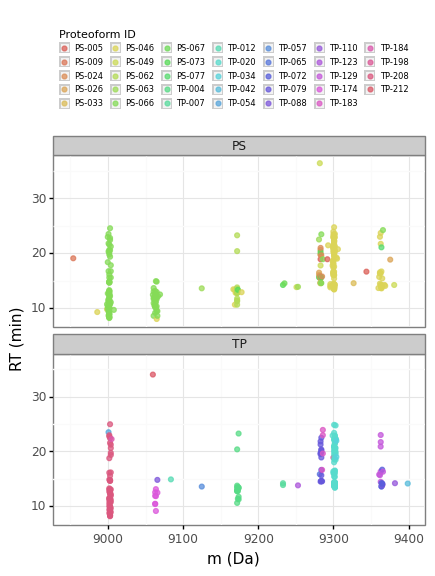

<ggplot: (-9223371930403195864)>

In [50]:
# Defining the figure size 1.2 x (4, 4)
p9.options.figure_size = (4.8, 4.8)

# Generating our ggplot
Fig3b = (ggplot(
                df[(df['m (Da)'] > 8950) & (df['m (Da)'] < 9400)].copy(),
                aes(
                    x='m (Da)',
                    y='RT (min)',
                    color='Proteoform ID',
                    fill='Proteoform ID',
                    )
                )
          + geom_point(
                       alpha=0.75,
                       )
          + facet_wrap(facets=['Node'], ncol=1)
          + guides(colour=guide_legend(ncol=7, override_aes={'alpha': 1}))
          + theme_bw()
          + xlim(8950, 9400)
          + theme(
                  legend_position="top",
                  legend_key_size=7,
                  legend_title=element_text(size=8),
                  legend_text=element_text(size=6)
                  )
          )

# Saving our ggplot
Fig3b.save(filename=f'{os.getcwd()}\\Output\\Figures\\png\\Fig3b.png', verbose=False)
Fig3b.save(filename=f'{os.getcwd()}\\Output\\Figures\\pdf\\Fig3b.pdf', verbose=False)

# Showing our ggplot
Fig3b

Here we will reproduce **Figure 3c** just as appears in the paper.

C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.
C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.


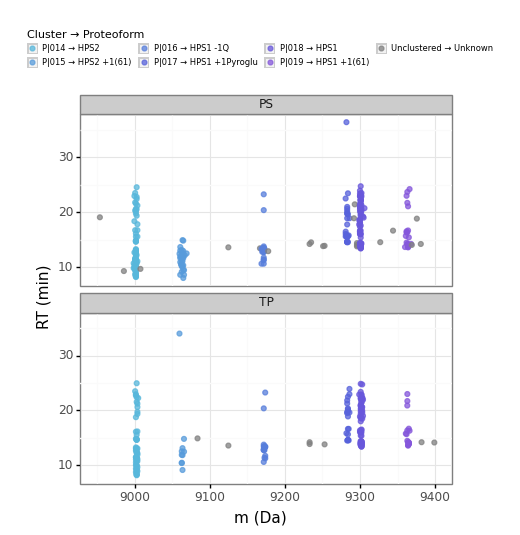

<ggplot: (-9223371930402653740)>

In [51]:
# Defining the figure size 1.2 x (4, 4)
p9.options.figure_size = (4.8, 4.8)

# Generating our ggplot
Fig3c = (ggplot(
                df[(df['m (Da)'] > 8950) & (df['m (Da)'] < 9400)].copy(),
                aes(
                    x='m (Da)',
                    y='RT (min)',
                    color='Cluster → Proteoform',
                    fill='Cluster → Proteoform',
                    )
                )
          + geom_point(
                       alpha=0.75,
                       )
          + facet_wrap(facets=['Node'], ncol=1)
          + scale_fill_manual(values=pal[15:21] + ['#808080'])
          + scale_color_manual(values=pal[15:21] + ['#808080'])
          + guides(colour=guide_legend(nrow=1, override_aes={'alpha': 1}))
          + theme_bw()
          + xlim(8950, 9400)
          + theme(
                  legend_position="top",
                  legend_key_size=7,
                  legend_title=element_text(size=8),
                  legend_text=element_text(size=6)
                  )
          )

del pal

# Saving our ggplot
Fig3c.save(filename=f'{os.getcwd()}\\Output\\Figures\\png\\Fig3c.png', verbose=False)
Fig3c.save(filename=f'{os.getcwd()}\\Output\\Figures\\pdf\\Fig3c.pdf', verbose=False)

# Showing our ggplot
Fig3c

In [52]:
del Fig3a, Fig3b, Fig3c

## Part 11 - Reproducing Supplementary Figure 1

Here we will reproduce **Figure S1a** just as appears in the supplementary materials.

C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.


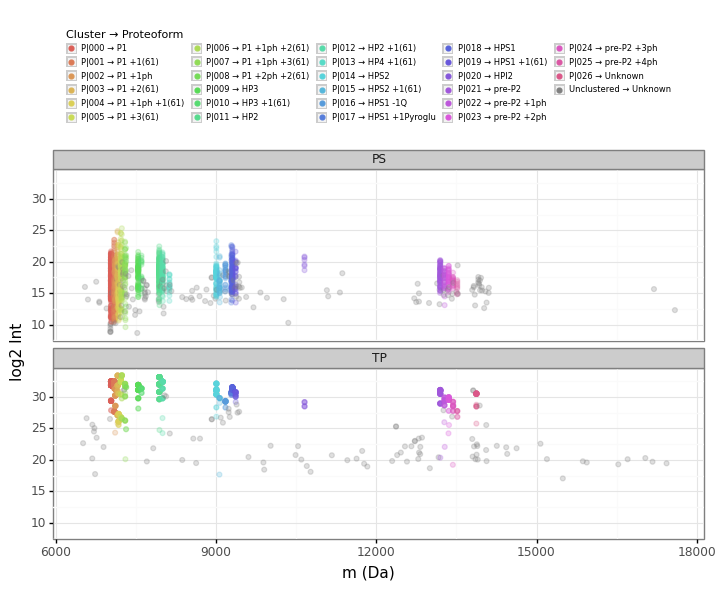

<ggplot: (-9223371930402647564)>

In [53]:
# Generating a palette with a different color for each cluster
pal = sns.color_palette('hls', len(df['Cluster → Proteoform'].unique()))

# HEX-converting the palette to make it suitable for ggplot
pal = list(pal.as_hex())

# Defining the last color of the palette as grey (for unclustered PrSMs)
pal[-1] = '#808080'

# Defining the figure size 1.2 x (7, 4)
p9.options.figure_size = (8.4, 4.8)

# Generating our ggplot
FigS1a = (ggplot(
                 df,
                 aes(
                     x='m (Da)',
                     y='log2 Int',
                     color='Cluster → Proteoform',
                     fill='Cluster → Proteoform',
                     )
                 )
          + geom_point(
                       alpha=0.25,
                       )
          + facet_wrap(facets=['Node'], ncol=1)
          + scale_fill_manual(values=pal)
          + scale_color_manual(values=pal)
          + guides(colour=guide_legend(override_aes={'alpha': 1}))
          + theme_bw()
          + theme(
                  legend_position="top",
                  legend_key_size=7,
                  legend_title=element_text(size=8),
                  legend_text=element_text(size=6)
                  )
          )

# Saving our ggplot
FigS1a.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\png\\FigS1a.png', verbose=False)
FigS1a.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\pdf\\FigS1a.pdf', verbose=False)

# Showing our ggplot
FigS1a

And here we will reproduce **Figure S1b** just as appears in the supplementary materials.

C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.
C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.


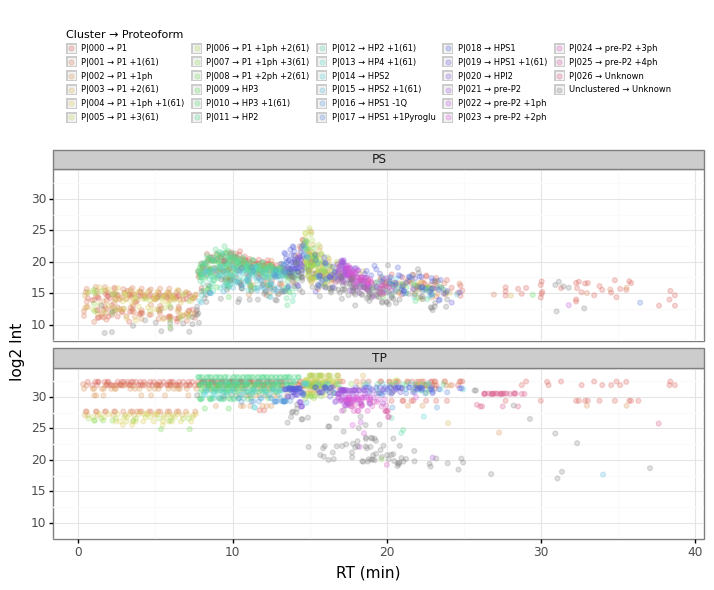

<ggplot: (-9223371930412561128)>

In [54]:
# Generating a palette with a different color for each cluster
pal = sns.color_palette('hls', len(df['Cluster → Proteoform'].unique()))

# HEX-converting the palette to make it suitable for ggplot
pal = list(pal.as_hex())

# Defining the last color of the palette as grey (for unclustered PrSMs)
pal[-1] = '#808080'

# Defining the figure size 1.2 x (7, 4)
p9.options.figure_size = (8.4, 4.8)

# Generating our ggplot
FigS1b = (ggplot(
                df,
                aes(
                    x='RT (min)',
                    y='log2 Int',
                    color='Cluster → Proteoform',
                    fill='Cluster → Proteoform',
                    )
                )
         + geom_point(
                      alpha=0.25,
                      )
         + facet_wrap(facets=['Node'], ncol=1)
         + scale_fill_manual(values=pal)
         + scale_color_manual(values=pal)
         + guides(colour=guide_legend(override_aes={'alpha': 1}))
         + theme_bw()
         + theme(
                 legend_position="top",
                 legend_key_size=7,
                 legend_title=element_text(size=8),
                 legend_text=element_text(size=6)
                 )
         )

# Saving our ggplot
FigS1b.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\png\\FigS1b.png', verbose=False)
FigS1b.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\pdf\\FigS1b.pdf', verbose=False)

# Showing our ggplot
FigS1b

In [55]:
del FigS1a, FigS1b

## Part 12 - Reproducing Supplementary Figure 2

Here we will reproduce **Figure S2a** just as appears in the supplementary materials.

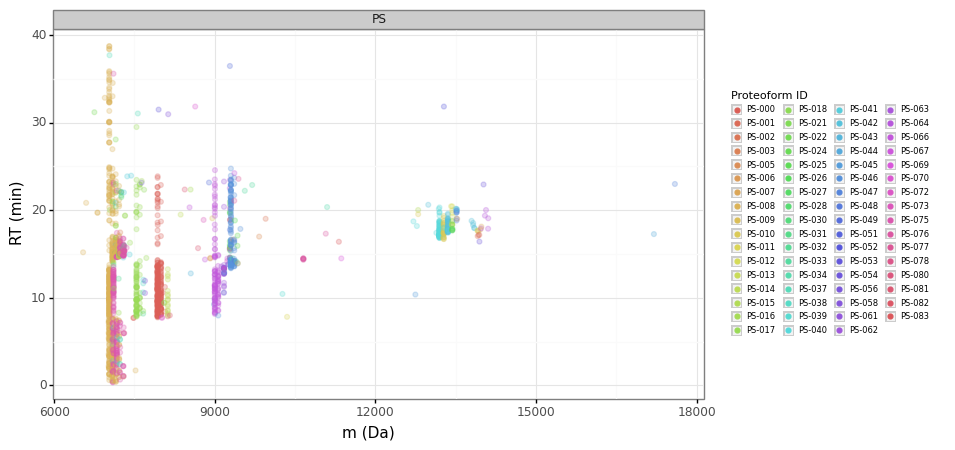

<ggplot: (-9223371930402746292)>

In [56]:
# Defining the figure size 1.2 x (7, 4)
p9.options.figure_size = (8.4, 4.8)

# Generating our ggplot
FigS2a = (ggplot(
                 df[df['Node'] == 'PS'],
                 aes(
                     x='m (Da)',
                     y='RT (min)',
                     color='Proteoform ID',
                     fill='Proteoform ID',
                     )
                 )
            + geom_point(
                         alpha=0.25,
                         )
            + facet_wrap(facets=['Node'], ncol=1)
            + guides(colour=guide_legend(override_aes={'alpha': 1}))
            + theme_bw()
            + theme(
                    legend_position="right",
                    legend_key_size=7,
                    legend_title=element_text(size=8),
                    legend_text=element_text(size=6)
                    )
            )

# Saving our ggplot
FigS2a.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\png\\FigS2a.png', verbose=False)
FigS2a.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\pdf\\FigS2a.pdf', verbose=False)

# Showing our ggplot
FigS2a

And here we will reproduce **Figure S2b** just as appears in the supplementary materials.

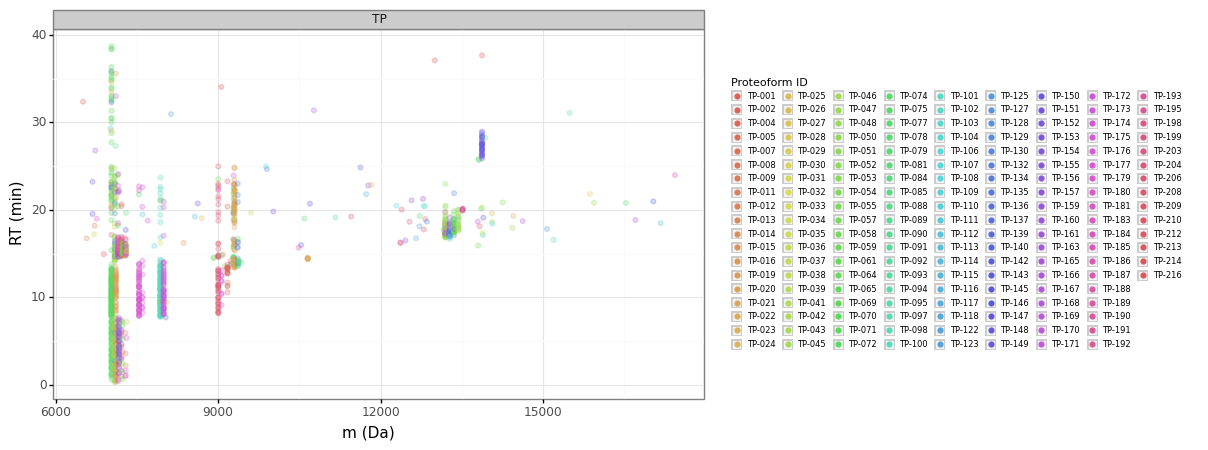

<ggplot: (-9223371930403354648)>

In [57]:
# Defining the figure size 1.2 x (7, 4)
p9.options.figure_size = (8.4, 4.8)

# Generating our ggplot
FigS2b = (ggplot(
                 df[df['Node'] == 'TP'],
                 aes(
                     x='m (Da)',
                     y='RT (min)',
                     color='Proteoform ID',
                     fill='Proteoform ID',
                     )
                 )
          + geom_point(
                       alpha=0.25,
                       )
          + facet_wrap(facets=['Node'], ncol=1)
          + guides(colour=guide_legend(override_aes={'alpha': 1}))
          + theme_bw()
          + theme(
                  legend_position="right",
                  legend_key_size=7,
                  legend_title=element_text(size=8),
                  legend_text=element_text(size=6)
                  )
          )

# Saving our ggplot
FigS2b.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\png\\FigS2b.png', verbose=False)
FigS2b.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\pdf\\FigS2b.pdf', verbose=False)

# Showing our ggplot
FigS2b

In [58]:
del FigS2a, FigS2b

## Part 13 - Reproducing Supplementary Figure 3

Before reproducing **Figure S3a** and **Figure S3b**, we need to differentiate between classified and unclassified PrSMs. <a id='Cell_b'></a>

In [59]:
# Masking classified/unclassified PrSMs (those that are known/unknown)
c_μ = df['Cluster - Protein (Revised)'] != 'Unknown'
uc_μ = df['Cluster - Protein (Revised)'] == 'Unknown'

# Tagging classified/unclassified PrSMs for incomming FigS6a and FigS6b
df.loc[c_μ, 'Outcome'] = 'Classified'
df.loc[uc_μ, 'Outcome'] = 'Unclassified'

del uc_μ, c_μ

In addition, let's compute some summary statistics numbers that we state in the paper body (Subsection 3.2.2).

In [60]:
# Grouping by 'Outcome' and counting thr number of PrSMs
pvt = df.groupby(by=['Outcome']).agg(Count=('Node', 'count'))

# Computing the PrSM count ratio by 'Outcome'
pvt['Ratio (%)'] = (pvt['Count'] / len(df)) * 100

# Showing table
pvt

,Count,Ratio (%)
Outcome,,
Classified,2550,89.852008
Unclassified,288,10.147992


In [61]:
# Grouping '-log E', 'z log2 Int' by 'Outcome' and 'Node' and aggregating both with 'mean'
df.groupby(by=['Outcome', 'Node']).agg({'-log E': 'mean', 'z log2 Int': 'mean'})

-log E  z log2 Int
Outcome      Node                       
Classified   PS    75.374421    0.100955
             TP    26.601542    0.182840
Unclassified PS    32.325422   -0.774772
             TP    11.053156   -1.911151

Here we will reproduce **Figure S3a** just as appears in the supplementary materials.

C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.


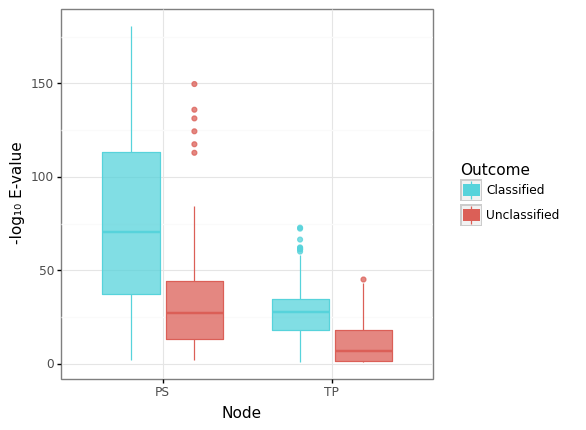

<ggplot: (-9223371930411589272)>

In [62]:
# Generating a palette with a different color for each outcome
pal = sns.color_palette('hls', len(df['Outcome'].unique()))

# HEX-converting the palette to make it suitable for ggplot
pal = list(pal.as_hex())

# Defining the figure size 1.2 x (4, 4)
p9.options.figure_size = (4.8, 4.8)

# Generating our ggplot
FigS3a = (ggplot(
                 df,
                 aes(
                     x='Node',
                     y='-log E',
                     color='Outcome',
                     fill='Outcome',
                     )
                 )
          + geom_boxplot(
                          alpha=0.75,
                          outlier_alpha=0.75,
                          )
          + scale_fill_manual(values=pal[::-1])
          + scale_color_manual(values=pal[::-1])
          + guides(colour=guide_legend(override_aes={'alpha': 1}))
          + theme_bw()
          + xlab('Node')
          + ylab('-log₁₀ E-value')
          )

del pal, pvt

# Saving our ggplot
FigS3a.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\png\\FigS3a.png', verbose=False)
FigS3a.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\pdf\\FigS3a.pdf', verbose=False)

# Showing our ggplot
FigS3a

And here we will reproduce **Figure S3b** just as appears in the supplementary materials.

C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.
C:\Users\garauz\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\guides\guide_legend.py:126: PlotnineWarning: Duplicated override_aes is ignored.


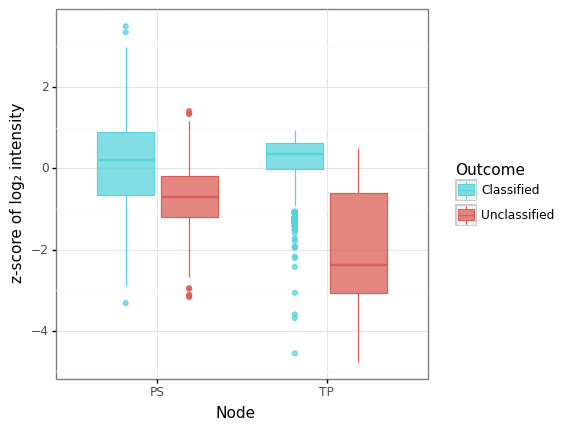

<ggplot: (-9223371930402936164)>

In [63]:
# Generating a palette with a different color for each outcome
pal = sns.color_palette('hls', len(df['Outcome'].unique()))

# HEX-converting the palette to make it suitable for ggplot
pal = list(pal.as_hex())

# Defining the figure size 1.2 x (4, 4)
p9.options.figure_size = (4.8, 4.8)

# Generating our ggplot
FigS3b = (ggplot(
                 df,
                 aes(
                     x='Node',
                     y='z log2 Int',
                     color='Outcome',
                     fill='Outcome',
                     )
                 )
          + geom_boxplot(
                         alpha=0.75,
                         outlier_alpha=0.75,
                         )
          + scale_fill_manual(values=pal[::-1])
          + scale_color_manual(values=pal[::-1])
          + guides(colour=guide_legend(override_aes={'alpha': 1}))
          + theme_bw()
          + xlab('Node')
          + ylab('z-score of log₂ intensity')
          )

del pal

# Saving our ggplot
FigS3b.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\png\\FigS3b.png', verbose=False)
FigS3b.save(filename=f'{os.getcwd()}\\Output\\SupplementaryFigures\\pdf\\FigS3b.pdf', verbose=False)

# Showing our ggplot
FigS3b

In [64]:
del FigS3a, FigS3b

## Part 14 - LandScape plots preparation

In order to prepare protamine proteoform LansScape plots, we just new a few columns from our PrSMs DataFrame `df`. We are going to slice-in those columns to work with an simplified DataFrame.

In [65]:
# Definig list of columns to slice-in
col1_list = [
             'Cluster - Protein (Revised)',
             'Cluster - Proteoform (Revised)',
             'Cluster - Δm (Da) (Revised)',
             'Cluster - Modification (Revised)',
             'Cluster - m (Da)',
             'log2 Int',
             'z log2 Int',
             'Outcome',
             ]

# Definig list of experimental desing columns to slice-in
col2_list = list(e.values()) + ['Node']

# Slicing-in interesting columns
df_landscape = df[col2_list + col1_list].copy()

del col2_list, col1_list

The column names we used in `df` are a bit bulky. Let's simplify them a bit.

In [66]:
# Defining standardizing renaming dictionary
uniform_dict = {
                'Cluster - Protein (Revised)':      'Form',
                'Cluster - Proteoform (Revised)':   'Proteoform',
                'Cluster - Δm (Da) (Revised)':      'Δm (Da)',
                'Cluster - Modification (Revised)': 'Modification',
                'Cluster - m (Da)':                 'm (Da)',
                'log2 Int':                         'Intensity (log2)',
                'z log2 Int':                       'Intensity (z)',
                }

# Standarizing column names
df_landscape.rename(columns=uniform_dict, inplace=True)

del uniform_dict

Now we will drop *unclassified* PrSMs (you can revisit this [code cell](#Cell_b) to recall this *classified* / *unclassified* categorization).

In [67]:
# Filtering in classified PrSMs for incomming LandScape plots
c_μ = df_landscape['Outcome'] == 'Classified'
df_landscape_f = df_landscape[c_μ].copy()

del c_μ, df_landscape

The following code chunk is the building block to generate a LandScape plot. We are going to prepare LandScapes at three levels (Global, BioRep and TechRep). In this first code cell we will prepare the LandScape data at the Global level. After, the execution, the data to generate the LandScape plot at the Global level will be stored in a DataFrame within the `df_gb_dict` dictionary.

In [68]:
# Initiating dataframe dictionary for incomming groupby
df_gb_dict = {}

# Rounding 'Δm (Da)' to enable proper grouping by
df_landscape_f['Δm (Da)'] = df_landscape_f['Δm (Da)'].round(2)

# Defining a list with the common grouping categories for incomming groupby
g_list = ['Form', 'Proteoform', 'Modification', 'Δm (Da)']
# We let 'Node' out to combine all the hits for both softs

# Initiating Excel writer to save spreadsheet with multiple sheets
writer = pd.ExcelWriter(f'{os.getcwd()}\\Output\\4_LandScapes.xlsx')

# Grouping by and aggregating 'I' with size to get number of hits...
gb_list = g_list
df_gb = df_landscape_f.groupby(by=gb_list).agg(PrSMs=('Outcome', 'count'))
df_gb.reset_index(drop=False, inplace=True)

# Sorting the main DataFrame to get sorted list of factors (hue)
df_gb.sort_values(by='Δm (Da)', inplace=True, ascending=False)

# Stablishing 'Modification' order to get a sorted hue
sorter_mod = list(df_gb['Modification'].unique())
df_gb['Modification'] = df_gb['Modification'].astype('category')
df_gb['Modification'].cat.set_categories(sorter_mod, inplace=True)

# Stablishing (by hand) 'Form' order to get a sorted x axis
sorter_prot = ['P1', 'HP3', 'HP2', 'HP4', 'HPS1', 'HPS2', 'HPI2', 'pre-P2']
df_gb['Form'] = df_gb['Form'].astype('category')
df_gb['Form'].cat.set_categories(sorter_prot, inplace=True)

# Storing the grouped DataFrame grouped in the DataFrame dictionary
df_gb_dict['Global'] = df_gb

# Writing the grouped DataFrame grouped
df_gb.to_excel(writer, sheet_name='Global', index=False)

del gb_list, df_gb

Similarly as we just did, now we are going to prepare the LandScape data at the BioRep and TechRep levels. We will implement a for loop to this aim. After the execution, the `df_gb_dict` dictionary should contain the LandScape data at all levels.

In [69]:
# For each category in the experimental design dictionary...
for cat in e.values():

    # Grouping by and aggregating 'I' with size to get number of hits...
    gb_list = [cat] + g_list
    df_gb = df_landscape_f.groupby(by=gb_list).agg(PrSMs=('Outcome', 'count'))
    df_gb.reset_index(drop=False, inplace=True)

    # Sorting the main DataFrame to get sorted list of factors (hue)
    df_gb.sort_values(by='Δm (Da)', inplace=True, ascending=False)

    # Stablishing 'Modification' order to get a sorted hue
    sorter_mod = list(df_gb['Modification'].unique())
    df_gb['Modification'] = df_gb['Modification'].astype('category')
    df_gb['Modification'].cat.set_categories(sorter_mod, inplace=True)

    # Stablishing (by hand) 'Form' order to get a a sorted x axis
    sorter_prot = ['P1', 'HP3', 'HP2', 'HP4', 'HPS1', 'HPS2', 'HPI2', 'pre-P2']
    df_gb['Form'] = df_gb['Form'].astype('category')
    df_gb['Form'].cat.set_categories(sorter_prot, inplace=True)

    # Storing the grouped DataFrame grouped in the DataFrame dictionary
    df_gb_dict[cat] = df_gb

    # Writing the grouped DataFrame grouped
    df_gb.to_excel(writer, sheet_name=cat, index=False)

del cat, g_list, df_gb, gb_list, sorter_mod, sorter_prot, df_landscape_f

Finally, we will export the LandScape data as an spreadsheet with a separated sheet for each level.

In [70]:
# Saving our Excel spreadsheet with LandScape data using multiple sheets 
writer.save()

## Part 15 - Reproducing Figure 4 (LandScapes)

Here we will reproduce **Figure 4a** just as appears in the paper.

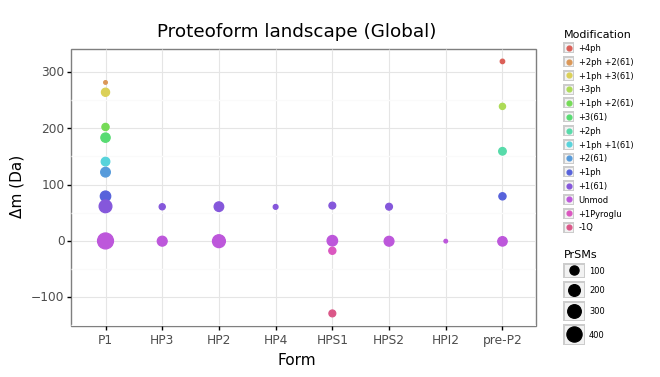

<ggplot: (-9223371930402823924)>

In [71]:
# Defining the figure size 1.2 x (5, 3)
p9.options.figure_size = (6.0, 3.6)

# Extracting LandScapes data by 'Global'
df_gb = df_gb_dict['Global']

# Plotting with ggplot
Fig4a = (ggplot(df_gb, aes(
                           x='Form',
                           y='Δm (Da)',
                           color='Modification',
                           size='PrSMs',
                           )
                )
         + ggtitle(f'Proteoform landscape (Global)')
         + geom_point(alpha=1)
         + theme_bw()
         + theme(axis_text_x=element_text(angle=0))
         + theme(
                 legend_position="right",
                 legend_key_size=7,
                 legend_title = element_text(size=8),
                 legend_text = element_text(size=6),
                 )
         )

# Saving our ggplot
Fig4a.save(filename=f'{os.getcwd()}\\Output\\Figures\\png\\\\Fig4a.png', verbose=False)
Fig4a.save(filename=f'{os.getcwd()}\\Output\\Figures\\pdf\\\\Fig4a.pdf', verbose=False)

# Showing our ggplot
Fig4a

Here we will reproduce **Figure 4b** just as appears in the paper.

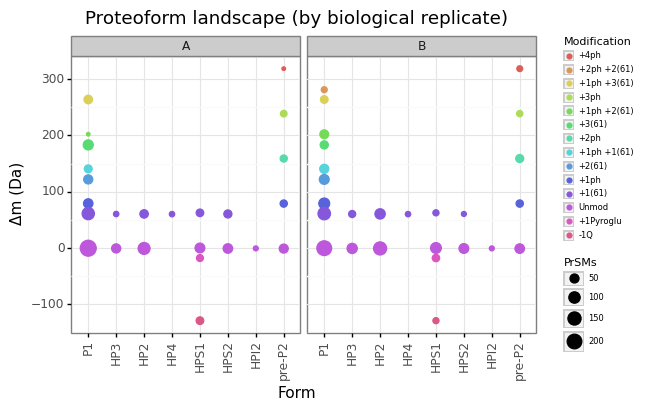

<ggplot: (-9223371930402431916)>

In [72]:
# Defining the figure size 1.2 x (5, 3)
p9.options.figure_size = (6.0, 3.6)

# Extracting LandScapes data by 'BioRep'
df_gb = df_gb_dict['BioRep']

# Plotting with ggplot
Fig4b = (ggplot(df_gb, aes(
                           x='Form',
                           y='Δm (Da)',
                           color='Modification',
                           size='PrSMs',
                           )
                )
         + ggtitle(f'Proteoform landscape (by biological replicate)')
         + geom_point(alpha=1)
         + facet_wrap('BioRep', ncol=2)
         + theme_bw()
         + theme(axis_text_x=element_text(angle=90))
         + theme(
                 legend_position="right",
                 legend_key_size=7,
                 legend_title = element_text(size=8),
                 legend_text = element_text(size=6)
                 )
         )

# Saving our ggplot
Fig4b.save(filename=f'{os.getcwd()}\\Output\\Figures\\png\\\\Fig4b.png', verbose=False)
Fig4b.save(filename=f'{os.getcwd()}\\Output\\Figures\\pdf\\\\Fig4b.pdf', verbose=False)

# Showing our ggplot
Fig4b

And here we will reproduce **Figure 4c** just as appears in the paper.

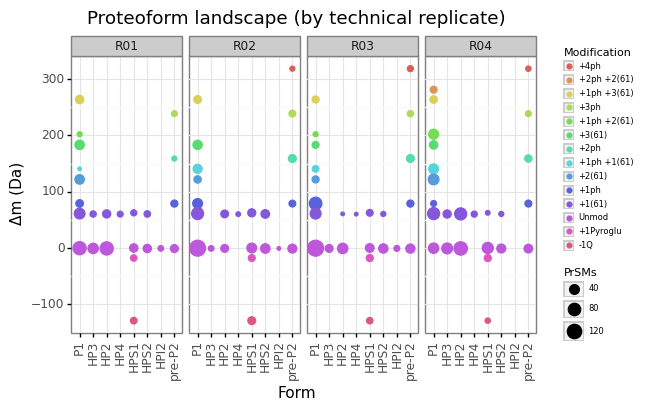

<ggplot: (-9223371930401924276)>

In [73]:
# Defining the figure size 1.2 x (5, 3)
p9.options.figure_size = (6.0, 3.6)

# Extracting LandScapes data by 'TechRep'
df_gb = df_gb_dict['TechRep']

# Plotting with ggplot
Fig4c = (ggplot(df_gb, aes(
                           x='Form',
                           y='Δm (Da)',
                           color='Modification',
                           size='PrSMs',
                           )
             )
         + ggtitle(f'Proteoform landscape (by technical replicate)')
         + geom_point(alpha=1)
         + facet_wrap('TechRep', ncol=4)
         + theme_bw()
         + theme(axis_text_x=element_text(angle=90))
         + theme(
                 legend_position="right",
                 legend_key_size=7,
                 legend_title=element_text(size=8),
                 legend_text=element_text(size=6)
                 )
         )

# Saving our ggplot
Fig4c.save(filename=f'{os.getcwd()}\\Output\\Figures\\png\\\\Fig4c.png', verbose=False)
Fig4c.save(filename=f'{os.getcwd()}\\Output\\Figures\\pdf\\\\Fig4c.pdf', verbose=False)

# Showing our ggplot
Fig4c

In [74]:
del Fig4a, Fig4b, Fig4c, df_gb, df_gb_dict

## Part 16 - Ratio plots preparation

After clustering, we have determined the proteoform associated to each cluster. All those proteoform belong to just three protamine "families", which are are P1, P2-immature and  P2-mature. Since we want to monitor P1/P2-mature' and P2-immature/P2-mature ratios, we first need to include such designation into our PrSMs DataFrame `df` .

In [75]:
# Initiating mapping dictionary to assign distinc ratio protamine families
p1p2_dict = {
             # P1 related proteoforms
             'P1':          'P1',
             # P2 related proteoforms
             'pre-P2':      'P2-immature',
             'HPI2':        'P2-immature',
             'HPS1':        'P2-immature',
             'HPS2':        'P2-immature',
             'HP4':         'P2-mature',
             'HP2':         'P2-mature',
             'HP3':         'P2-mature',
             # P2-2 related proteoforms
             'P2-2':        'P2-immature',
             }

# Mapping revised cluster proteins with their corresponding "Mother Proteins"
df['Protamine'] = df['Cluster - Protein (Revised)'].map(p1p2_dict)

del p1p2_dict

Now we will drop *unclassified* PrSMs (you can revisit this [code cell](#Cell_b) to recall this *classified* / *unclassified* categorization).

In [76]:
# Filtering in classified PrSMs for incomming LandScape plots
c_μ = df['Outcome'] == 'Classified'
df_ratio = df[c_μ].copy()

del c_μ

At this point we can obtain the intensity associated to each protamine "family" just by summing individual PrSM intensity by `'File'` and `'Node'`:

In [77]:
# Pivoting and aggregating the linear Intensity by 'Replicate' and 'Engine'
pvt_ratio = pd.pivot_table(df_ratio,
                           values='Int',
                           index=['File', 'Node'],
                           columns=['Protamine'],
                           aggfunc=sum)

del df_ratio

Let's transform summed intensities to $log_2$ to then compute the two ratios we want ratios.

In [78]:
# Transforming the summed linear intensities into log2
pvt_ratio = pvt_ratio.apply(np.log2)

# Extracting series for incomming (Protamine) ratio computations
P1 = pvt_ratio['P1']
P2_m = pvt_ratio['P2-mature']
P2_im = pvt_ratio['P2-immature']

# Computing Protamine ratios
pvt_ratio['P1/P2-mature'] = P1 / P2_m
pvt_ratio['P2-immature/P2-mature'] = P2_im / P2_m

# Resetting index to recover associated 'Replicate' and 'Node'
pvt_ratio.reset_index(drop=False, inplace=True)

del P1, P2_im, P2_m

Now we can again extract the experimental design from the spectrum file names stored in the `'File'` column (you can revisit this [code cell](#Cell_c) to recall this step). Remember that we have two biological replicates (`'A'` and `'B'`) with two technical replicates each (`'R01'`, `'R02'` and `'R03'`, `'R04'`, respectively). 

In [79]:
# Extracting the experimental desing from the file name
for k in sorted(e.keys(), reverse=True):
    # Incorporating the experimental desing as categorical columns
    pvt_ratio.insert(0, e[k], pvt_ratio['File'].str.split('_').str[k])

del k

# Dropping futile 'File' column
pvt_ratio.drop(columns=['File'], inplace=True)

Since we want to monitor P1/P2-mature' and P2-immature/P2-mature ratio at all levels (Global, BioRep and TechRep), we need to add a mock `'Global'` column. After that we should melt the pivoted ratio DataFrame `pvt_ratio` in order to get a tidy format suitable for `ggplot`.

In [80]:
# Adding a mock 'Global' column
pvt_ratio['Global'] = ''

# Melting both 'Ratio' 'Value's ('P1/P2-mature' and 'P2-immature/P2-mature')
melt_ratio = pvt_ratio.melt(id_vars=['Global', 'BioRep', 'TechRep', 'Node'],
                            value_vars=['P1/P2-mature', 'P2-immature/P2-mature'],
                            var_name='Ratio',
                            value_name='Value')

del pvt_ratio

Finally, we need to compute the `'mean'` of each `'Node'`, `'Ratio' ` pair at all levels (`'Global'`, `'BioRep'` and `'TechRep'`). Here we will also compute the up and down bounds as `'mean'` ± `'std'` for the `'Global'` level. We need to do this by hand in order to show error bars in the following protamine ratio plots.

In [81]:
# Computing means of each 'Node', 'Ratio' pair for all levels
melt_ratio['Global (mean)'] = melt_ratio.groupby(by=['Global', 'Node', 'Ratio'])['Value'].transform('mean')
melt_ratio['BioRep (mean)'] = melt_ratio.groupby(by=['BioRep', 'Node', 'Ratio'])['Value'].transform('mean')
melt_ratio['TechRep (mean)'] = melt_ratio.groupby(by=['TechRep', 'Node', 'Ratio'])['Value'].transform('mean')

# Computing standard deviations of each 'Node', 'Ratio' pair for all levels
melt_ratio['Global (std)'] = melt_ratio.groupby(by=['Global', 'Node', 'Ratio'])['Value'].transform('std')

# Computing up bounds of each 'Node', 'Ratio' pair for all levels
melt_ratio['Global (up)'] = melt_ratio['Global (mean)'] + melt_ratio['Global (std)']

# Computing down bounds of each 'Node', 'Ratio' pair for all levels
melt_ratio['Global (down)'] = melt_ratio['Global (mean)'] - melt_ratio['Global (std)']

## Part 17 - Reproducing Figure 4 (Ratios)

Here we will reproduce **Figure 4d** just as appears in the paper.

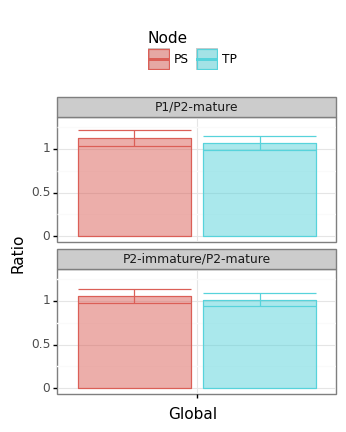

<ggplot: (-9223371930403748724)>

In [82]:
# Defining the figure size 1.2 x (3, 3)
p9.options.figure_size = (3.6, 3.6)

# Plotting with ggplot
Fig4d = (ggplot(melt_ratio.drop_duplicates(subset=['Global (mean)']),
                aes(
                    x='Global',
                    y='Global (mean)',
                    color='Node',
                    fill='Node',
                    )
                 )
         + geom_col(
                    position=position_dodge2(width=0.9, preserve="single"),
                    alpha=0.5,
                    )
         + geom_errorbar(
                         aes(
                             ymin='Global (down)',
                             ymax='Global (up)',
                             ),
                         width=0.9,
                         position=position_dodge2(preserve="single")
                         )
         + ylab('Ratio')
         + xlab('Global')
         + ylim(0, 1.3)
         + facet_wrap('Ratio', ncol=1)
         + theme_bw()
         + theme(legend_position="top")
         )

# Saving our ggplot
Fig4d.save(filename=f'{os.getcwd()}\\Output\\Figures\\png\\\\Fig4d.png', verbose=False)
Fig4d.save(filename=f'{os.getcwd()}\\Output\\Figures\\pdf\\\\Fig4d.pdf', verbose=False)

# Showing our ggplot
Fig4d

Here we will reproduce **Figure 4e** just as appears in the paper.

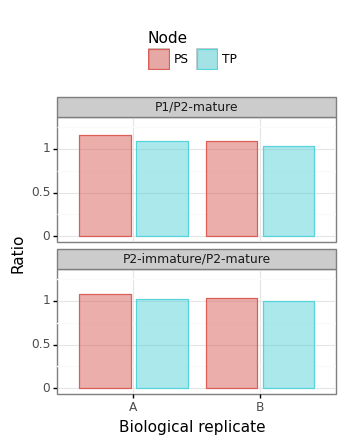

<ggplot: (-9223371930403381488)>

In [83]:
# Defining the figure size 1.2 x (3, 3)
p9.options.figure_size = (3.6, 3.6)

# Plotting with ggplot
Fig4e = (ggplot(melt_ratio.drop_duplicates(subset=['BioRep (mean)']),
                aes(
                    x='BioRep',
                    y='BioRep (mean)',
                    color='Node',
                    fill='Node'
                    )
                )
         + geom_col(
                    position=position_dodge2(width=0.9, preserve="single"),
                    alpha=0.5,
                    )
         + ylab('Ratio')
         + xlab('Biological replicate')
         + ylim(0, 1.3)
         + facet_wrap('Ratio', ncol=1)
         + theme_bw()
         + theme(legend_position="top")
         )

# Saving our ggplot
Fig4e.save(filename=f'{os.getcwd()}\\Output\\Figures\\png\\\\Fig4e.png', verbose=False)
Fig4e.save(filename=f'{os.getcwd()}\\Output\\Figures\\pdf\\\\Fig4e.pdf', verbose=False)

# Showing our ggplot
Fig4e

And here we will reproduce **Figure 4f** just as appears in the paper.

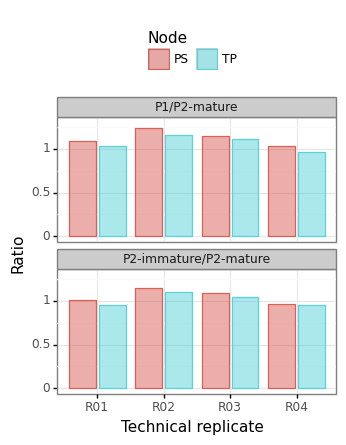

<ggplot: (-9223371930403114660)>

In [84]:
# Defining the figure size 1.2 x (3, 3)
p9.options.figure_size = (3.6, 3.6)

# Plotting with ggplot
Fig4f = (ggplot(melt_ratio.drop_duplicates(subset=['TechRep (mean)']),
                aes(
                    x='TechRep',
                    y='TechRep (mean)',
                    color='Node',
                    fill='Node',
                    )
                 )
         + geom_col(
                    position=position_dodge2(width=0.9, preserve="single"),
                    alpha=0.5,
                    )
         + ylab('Ratio')
         + xlab('Technical replicate')
         + ylim(0, 1.3)
         + facet_wrap('Ratio', ncol=1)
         + theme_bw()
         + theme(legend_position="top")
         )

# Saving our ggplot
Fig4f.save(filename=f'{os.getcwd()}\\Output\\Figures\\png\\\\Fig4f.png', verbose=False)
Fig4f.save(filename=f'{os.getcwd()}\\Output\\Figures\\pdf\\\\Fig4f.pdf', verbose=False)

# Showing our ggplot
Fig4f

In [85]:
del Fig4d, Fig4e, Fig4f, melt_ratio

## Part 18 - PTMs localization plots preparation

We will restrict the PTM localization analysis just to the phosphorylation PTM. Let's filter them in.

In [86]:
# Masking those PrSMs with the 'phospho' or 'Phospho' keywords
ph_μ = df['Modifications'].str.contains('|'.join(['phospho', 'Phospho']))

# Filtlering-in those PrSMs with the 'phospho' or 'Phospho' keywords
df_ph = df[ph_μ].copy()

del ph_μ

As a preliminary step to generate the PTMs localization plots, we need to get an "extended" version of the PrSMs DataFrame with the information regarding the PTM localization in separated rows. We didn't found an elegant clean way to achieve this, so we apologize in advance for the cumbersomeness of the next code cells.

In [87]:
# Creating a list with the columns that DO contain lists
YesStack_cols = ['Targets', 'Positions', 'Positions (abs.)', 'Probabilities']

# Creating a list with the columns that DO NOT contain lists
NonStack_cols = [col for col in df_ph.columns if col not in YesStack_cols]

# Computing the length of the longest list in the 'Targets' column (for the incoming stack)
longest = df_ph['Targets'].map(len).max()

# Initializing an empty dataframe for incoming extending
df_ph_stack = pd.DataFrame({})

# Extending each cell in df_ph (for the incoming stack)
for col in NonStack_cols:

    # Replacing each cell by a 'longest'-times repeated list (for the incoming stack)
    df_ph_stack[col] = df_ph[col].apply(lambda cell: [cell] * longest)

del longest, col, NonStack_cols

This `df_ph_stack` is a very bulky DataFrame with the sole purpose of being "stacked" in the next code cell.

In [88]:
# Incorporating the columns that DO contain lists from df_ph to df_ph_stack
df_ph_stack[YesStack_cols] = df_ph[YesStack_cols]

# Initializing empty dataframe for incoming stacking
df_site = pd.DataFrame({})

# Stacking the lists inside each df_ph_stack colum
for col in df_ph_stack.columns:
    
    # Stacking the lists inside each df_ph_stack colum
    df_site[col] = df_ph_stack[col].apply(pd.Series).stack()

del col, df_ph_stack, YesStack_cols

In turn, the `df_site` is a redundant DataFrame. We need to remove filling and duplicated instances in the next code cell.

In [89]:
# Resetting index
df_site.reset_index(drop=True, inplace=True)

# Renaming columns because now we have one "Target" by row
df_site.rename(columns={'Targets': 'Target',
                        'Positions': 'Position',
                        'Positions (abs.)': 'Position (abs.)',
                        'Probabilities': 'Probability'},
               inplace=True)

# Masking non-filling entries
NonFilling_μ = df_site['Target'] != ''

# Filtering-in non-filling entries
df_site = df_site[NonFilling_μ].copy()

# Dropping duplicated entries
df_site.dropna(subset=['Target'], inplace=True)

del NonFilling_μ

At this moment, we have nice `'Position (abs.)'` and `'Target'` columns. Starting from this column pair we will construct a extra `'Site'` column just for aesthetics reasons when plotting.

In [90]:
# Cohercing integer datatpype
df_site['Position (abs.)'] = df_site['Position (abs.)'].astype('int')

# Storing 'Target' as Series
target_ser = df_site['Target']

# Cohercing string datatpype and storing 'Position (abs.)' as Series
position_ser = df_site['Position (abs.)'].astype('str')

# Creating the 'Site' column by hand
df_site['Site'] = target_ser + '-' + position_ser

del target_ser, position_ser

Now we need to select only those site assigments in which our `'Cluster - Protein (Revised)'` sequence includes the associated PrSM sequence.

In [91]:
# Preparing supporting UDF
def match1(f):
    '''TODO'''
    return f['Cluster - Protein (Revised)'] in f['Proteins (own search)']

# Masking if 'Cluster - Protein (Revised)' is found among 'Proteins (own search)'
match1_μ = df_site.apply(match1, axis=1)

# Filtering-in matching entries
df_site_m1 = df_site[match1_μ].copy()

# Creating a column with the whole 'Cluster - Protein (Revised)' sequence associated to the PrSM sequence
df_site_m1['Full seq.'] = df_site_m1['Cluster - Protein (Revised)'].map(pf_seq_dict)

del df_site, match1_μ

TODO

In [92]:
# TODO
def f(f):
    try:
        return f['Full seq.'][f['Position (abs.)'] - 2]
    except:
        IndexError

# TODO
df_site_m1['Cluster target'] = df_site_m1.apply(f, axis=1)

# TODO
df_site_m1['Match 2'] = df_site_m1['Target'] == df_site_m1['Cluster target']

# TODO
SITE_PROB_df_f2 = df_site_m1[df_site_m1['Match 2']].copy()

TODO

In [94]:
# Filtering-in good candidates

TP_μ = SITE_PROB_df_f2['Node'] == 'TP'
TP_ok_μ = SITE_PROB_df_f2['Probability'] > 75

PS_μ = SITE_PROB_df_f2['Node'] == 'PS'
PS_ok_μ = SITE_PROB_df_f2['C-Score'] > 40

Zn_μ = SITE_PROB_df_f2['Cluster - Modification (Revised)'].str.contains('61')

SITE_PROB_df_f3 = SITE_PROB_df_f2[( (TP_μ & TP_ok_μ) | (PS_μ & PS_ok_μ) ) & ~Zn_μ].copy()

del TP_μ, TP_ok_μ, PS_μ, PS_ok_μ

TODO

In [95]:
ph_λ = lambda c: re.findall(r'\+(.*)ph', c)
SITE_PROB_df_f3['Cluster - Count (ph)'] = SITE_PROB_df_f3['Cluster - Modification (Revised)'].apply(ph_λ)
SITE_PROB_df_f3['Cluster - Count (ph)'] = SITE_PROB_df_f3['Cluster - Count (ph)'].str[0].fillna(0).apply(int)

count_ok_μ = SITE_PROB_df_f3['Cluster - Count (ph)'] == SITE_PROB_df_f3['Count (ph)']

SITE_PROB_df_f4 = SITE_PROB_df_f3[count_ok_μ].copy()

# Exporting the main DataFrame
SITE_PROB_df_f4.to_excel(f'{os.getcwd()}\\Output\\5_Phospho.xlsx', index=False)

## Part 19 - Reproducing Figure 5

Here we will reproduce **Figure 5** just as appears in the paper.

In [96]:
# TODO
pptm = SITE_PROB_df_f4.groupby(by=['Node', 'Cluster - Protein (Revised)', 'Cluster - Proteoform (Revised)', 'Cluster - Modification (Revised)', 'Site'], as_index=False).agg('count')

In [97]:
# TODO
pptm['Site'] = pd.Categorical(
                              values=pptm['Site'],
                              categories=['Y-4', 'S-8', 'S-10', 'S-11', 'S-13', 'Y-16', 'S-22', 'Y-44', 'S-51', 'S-59', 'T-98'],
                              ordered=True,
                              )

pptm['Site'].unique()

['S-11', 'S-10', 'S-8', 'Y-4', 'T-98', ..., 'S-22', 'Y-16', 'Y-44', 'S-51', 'S-59']
Length: 11
Categories (11, object): ['Y-4' < 'S-8' < 'S-10' < 'S-11' ... 'Y-44' < 'S-51' < 'S-59' < 'T-98']

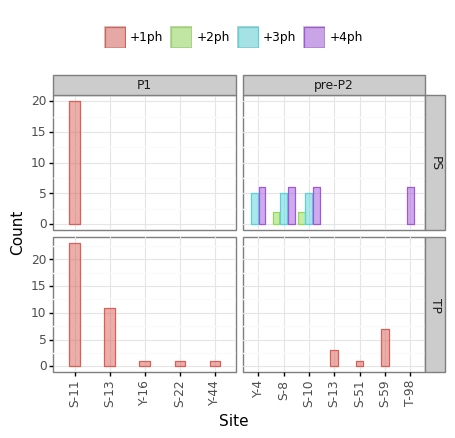

<ggplot: (-9223371930412229516)>

In [98]:
# Defining the figure size 1.2 x (4, 3)
p9.options.figure_size = (4.8, 3.6)

# Plotting with ggplot
Fig5 = (ggplot(pptm,
               aes(
                   x='Site',
                   y='Scan',
                   color='Cluster - Modification (Revised)',
                   fill='Cluster - Modification (Revised)',
                   )
               )
        + geom_col(
                   position=position_dodge2(width=0.9, preserve="single"),
                   alpha=0.5,
                   )
        + theme_bw()
        + theme(legend_position="top", legend_title=element_blank())
        + theme(axis_text_x=element_text(
                                         ha='top',
                                         angle=90,
                                         vjust=1.0,
                                         hjust=0.5,
                                         )
                )
        + facet_grid(['Node', 'Cluster - Protein (Revised)'], scales="free")
        + ylab('Count')
        )

# Saving our ggplot
Fig5.save(filename=f'{os.getcwd()}\\Output\\Figures\\png\\\\Fig5.png', verbose=False)
Fig5.save(filename=f'{os.getcwd()}\\Output\\Figures\\pdf\\\\Fig5.pdf', verbose=False)

# Showing our ggplot
Fig5

In [99]:
del Fig5